# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [ ]:
# run this once to unzip the file
!unzip processed-celeba-small.zip

Archive:  processed-celeba-small.zip
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [103]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from torchvision.io import decode_image
import os

import tests

In [104]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [ ]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    transforms = [ToTensor()
                 , Resize(size)
                 , Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])]
    
    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [ ]:
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        self.directory = directory
        self.transforms = transforms
        self.extension = extension
        self.image_paths = [os.path.join(directory, filename) for filename in os.listdir(directory) if filename.endswith(extension)]
        
    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        return len(self.image_paths)

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')
        
        if self.transforms:
            image = self.transforms(image)
            
        return image

In [107]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

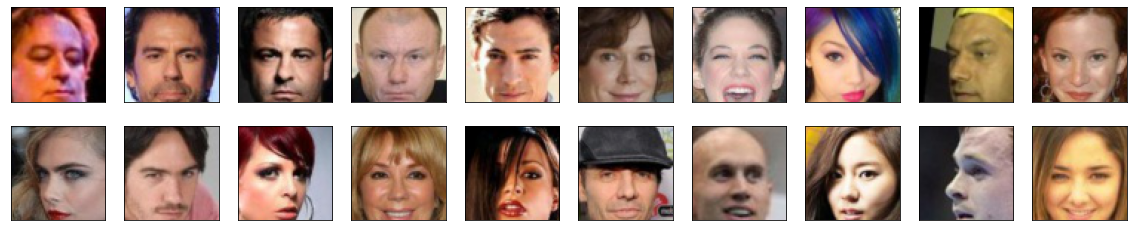

In [108]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [109]:
from torch.nn import Module
import torch.nn as nn

In [ ]:
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
       
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 4, stride = 2, padding = 1, bias = False) # 64 input, 32 output
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 4, stride = 2, padding = 1, bias = False) # 32 input, 16 output
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False)# 16 input, 8 output
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False)# 8 input, 4 output
        self.bn4 = nn.BatchNorm2d(256)
        
        # Final layer to get single output
        self.conv5 = nn.Conv2d(256, 1, kernel_size = 4, stride = 1, padding = 0, bias = False)# 8 input, 4 output

        self.activation = nn.LeakyReLU(0.2)
        
        self.act_out = nn.Sigmoid()
        
        # Flatten the output for FullyConnected Layer
#         self.flatten = nn.Flatten()
        
        # Fully Connected Layer
#         self.fc = nn.Linear(256*4*4, 1)# 256 is output of conv layer featuremap 
                                            #and 4 is output dimension of the image after the last conv layer

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        x = self.activation(self.conv1(x))
        x = self.activation(self.bn2(self.conv2(x)))
        x = self.activation(self.bn3(self.conv3(x)))
        x = self.activation(self.bn4(self.conv4(x)))
        x = self.conv5(x)
#         x = self.act_out(self.conv5(x))
        
        
#         x = self.flatten(x) # when flatten is applied, score generated shape [1,1]
#         x = self.fc(x) # when flatten is not applied, score generated shape [1,1,1,1]
            # to pass the tests given in tests.py for Discriminator linear layer is removed 
            # and ony conv layer is used to get 1 channel output
        
        return x 

In [111]:
D = Discriminator()
print(D)
images = torch.randn(1, 3, 64, 64)
score = D(images)
score.shape

Discriminator(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (activation): LeakyReLU(negative_slope=0.2)
  (act_out): Sigmoid()
)


torch.Size([1, 1, 1, 1])

In [112]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [ ]:
class Generator(Module):
    def __init__(self, latent_dim: int):
        super(Generator, self).__init__()
        
        self.deconv1 = nn.ConvTranspose2d(latent_dim, 256, kernel_size = 4, stride = 1, padding = 0, bias = False)
        self.bn1 = nn.BatchNorm2d(256) #4*4 out
        
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(128) #8*8 out
        
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(64) #16*16 out
        
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.bn4 = nn.BatchNorm2d(32) #32*32 out
        
        self.deconv5 = nn.ConvTranspose2d(32, 3, kernel_size = 4, stride = 2, padding = 1, bias = False)
         #64*64 out
        
        self.activation = nn.ReLU()
        
        self.act_out = nn.Tanh()
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.activation(self.bn1(self.deconv1(x)))
        x = self.activation(self.bn2(self.deconv2(x)))
        x = self.activation(self.bn3(self.deconv3(x)))
        x = self.activation(self.bn4(self.deconv4(x)))
        x = self.act_out(self.deconv5(x))
                
        return x

In [114]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [ ]:
import torch.optim as optim


def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    g_optimizer = optim.Adam(generator.parameters(), lr = 0.0003, betas = (0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr = 0.0003, betas = (0.5, 0.999))
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [116]:
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
def generator_loss(fake_logits):
    """ Generator loss, takes the fake scores as inputs. """
    label1s = torch.ones_like(fake_logits).to(device)
    
    loss = criterion(fake_logits, label1s*0.9)
    
    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [ ]:
def discriminator_loss(real_logits, fake_logits):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    label1s = torch.ones_like(real_logits).to(device)
    real_loss = criterion(real_logits, label1s*0.9)
    
    label0s = torch.zeros_like(fake_logits).to(device)
    fake_loss = criterion(fake_logits, label0s)
    
    loss = real_loss + fake_loss
    
    return loss

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [ ]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    """ This function enforces """
    gp = 0
    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [ ]:
def generator_step(batch_size: int, latent_dim: int) -> Dict:
    """ One training step of the generator. """
    
    g_optimizer.zero_grad()
    
    z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
    
    # Generate fake image with Generator
    fake_image4g = generator(z)
    
    # Getting logits from Discriminator
    fake_g_logits = discriminator(fake_image4g)
    
    # Loss Calculation
    g_loss = generator_loss(fake_g_logits)
    
    # Backward pass
    g_loss.backward()
    g_optimizer.step()
    
    return {'loss': g_loss}


In [ ]:
def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor) -> Dict:
    """ One training step of the discriminator. """
    d_optimizer.zero_grad()
    
    # Generating z1 vector to create fake image
    z1 = torch.randn(batch_size, latent_dim, 1, 1).to(device)
    
    # Apply discriminator on fake image
    fake_image4d = generator(z1).detach() # Detach to stop gradient update at this step
    fake_d_logits = discriminator(fake_image4d) 
    
    # Apply discriminator on real image
    real_d_logits = discriminator(real_images)
    
    # loss function
    d_loss = discriminator_loss(real_d_logits, fake_d_logits)
    
    # Backpropagation
    d_loss.backward()
    
    # Optimizer step
    d_optimizer.step()
    
    gp = gradient_penalty(discriminator, real_images, z1)
    
    return {'loss': d_loss, 'gp': gp}

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [122]:
from datetime import datetime

In [123]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = 'cuda'

# number of epochs to train your model
n_epochs = 1

# number of images in each batch
batch_size = 64

In [124]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [125]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

2025-08-01 02:28:53 | Epoch [1/25] | Batch 0/509 | d_loss: 0.4101 | g_loss: 3.8995
2025-08-01 02:28:55 | Epoch [1/25] | Batch 50/509 | d_loss: 0.4767 | g_loss: 3.7936
2025-08-01 02:28:58 | Epoch [1/25] | Batch 100/509 | d_loss: 0.4165 | g_loss: 3.4358
2025-08-01 02:29:01 | Epoch [1/25] | Batch 150/509 | d_loss: 0.4559 | g_loss: 4.7404
2025-08-01 02:29:03 | Epoch [1/25] | Batch 200/509 | d_loss: 0.7203 | g_loss: 7.0231
2025-08-01 02:29:06 | Epoch [1/25] | Batch 250/509 | d_loss: 0.4404 | g_loss: 4.0519
2025-08-01 02:29:09 | Epoch [1/25] | Batch 300/509 | d_loss: 0.4136 | g_loss: 3.9266
2025-08-01 02:29:12 | Epoch [1/25] | Batch 350/509 | d_loss: 0.4252 | g_loss: 3.3978
2025-08-01 02:29:14 | Epoch [1/25] | Batch 400/509 | d_loss: 0.7417 | g_loss: 2.5445
2025-08-01 02:29:17 | Epoch [1/25] | Batch 450/509 | d_loss: 0.3958 | g_loss: 4.5357
2025-08-01 02:29:20 | Epoch [1/25] | Batch 500/509 | d_loss: 0.4091 | g_loss: 3.8091


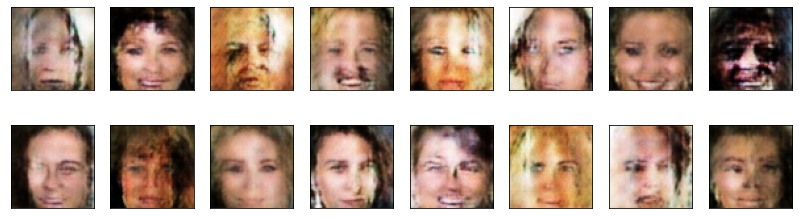

2025-08-01 02:29:23 | Epoch [2/25] | Batch 0/509 | d_loss: 0.4122 | g_loss: 3.9799
2025-08-01 02:29:26 | Epoch [2/25] | Batch 50/509 | d_loss: 0.3908 | g_loss: 4.2963
2025-08-01 02:29:28 | Epoch [2/25] | Batch 100/509 | d_loss: 0.4033 | g_loss: 4.0534
2025-08-01 02:29:31 | Epoch [2/25] | Batch 150/509 | d_loss: 0.4829 | g_loss: 3.1153
2025-08-01 02:29:34 | Epoch [2/25] | Batch 200/509 | d_loss: 0.4180 | g_loss: 3.5380
2025-08-01 02:29:37 | Epoch [2/25] | Batch 250/509 | d_loss: 0.3911 | g_loss: 4.1299
2025-08-01 02:29:40 | Epoch [2/25] | Batch 300/509 | d_loss: 0.3823 | g_loss: 4.0059
2025-08-01 02:29:42 | Epoch [2/25] | Batch 350/509 | d_loss: 0.6994 | g_loss: 6.0213
2025-08-01 02:29:45 | Epoch [2/25] | Batch 400/509 | d_loss: 0.4638 | g_loss: 3.5668
2025-08-01 02:29:48 | Epoch [2/25] | Batch 450/509 | d_loss: 0.4881 | g_loss: 3.0832
2025-08-01 02:29:51 | Epoch [2/25] | Batch 500/509 | d_loss: 0.4231 | g_loss: 3.0217


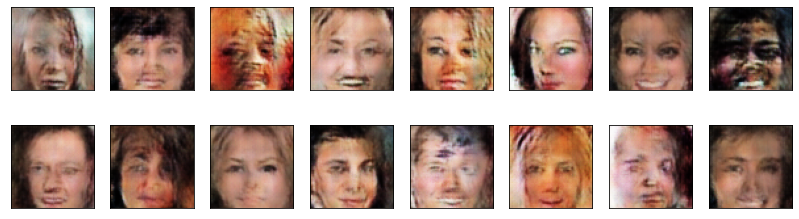

2025-08-01 02:29:54 | Epoch [3/25] | Batch 0/509 | d_loss: 0.6864 | g_loss: 6.7963
2025-08-01 02:29:57 | Epoch [3/25] | Batch 50/509 | d_loss: 0.4010 | g_loss: 4.4400
2025-08-01 02:29:59 | Epoch [3/25] | Batch 100/509 | d_loss: 0.5456 | g_loss: 3.6810
2025-08-01 02:30:02 | Epoch [3/25] | Batch 150/509 | d_loss: 0.4233 | g_loss: 4.6347
2025-08-01 02:30:05 | Epoch [3/25] | Batch 200/509 | d_loss: 0.3825 | g_loss: 3.5850
2025-08-01 02:30:07 | Epoch [3/25] | Batch 250/509 | d_loss: 0.3780 | g_loss: 4.8457
2025-08-01 02:30:10 | Epoch [3/25] | Batch 300/509 | d_loss: 0.3733 | g_loss: 4.4338
2025-08-01 02:30:13 | Epoch [3/25] | Batch 350/509 | d_loss: 0.6905 | g_loss: 4.9355
2025-08-01 02:30:16 | Epoch [3/25] | Batch 400/509 | d_loss: 0.5129 | g_loss: 4.1777
2025-08-01 02:30:18 | Epoch [3/25] | Batch 450/509 | d_loss: 0.3991 | g_loss: 3.6727
2025-08-01 02:30:21 | Epoch [3/25] | Batch 500/509 | d_loss: 0.3935 | g_loss: 4.5672


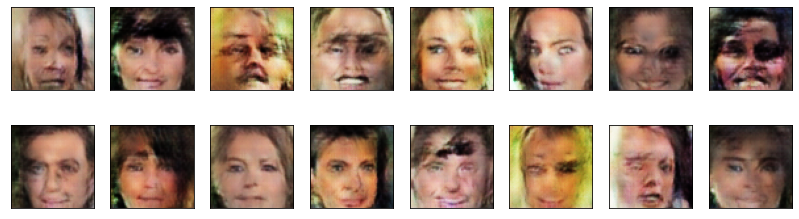

2025-08-01 02:30:24 | Epoch [4/25] | Batch 0/509 | d_loss: 0.3956 | g_loss: 4.5916
2025-08-01 02:30:27 | Epoch [4/25] | Batch 50/509 | d_loss: 0.4219 | g_loss: 3.3619
2025-08-01 02:30:30 | Epoch [4/25] | Batch 100/509 | d_loss: 0.4290 | g_loss: 3.2959
2025-08-01 02:30:33 | Epoch [4/25] | Batch 150/509 | d_loss: 0.4106 | g_loss: 3.8282
2025-08-01 02:30:35 | Epoch [4/25] | Batch 200/509 | d_loss: 0.5252 | g_loss: 4.0053
2025-08-01 02:30:38 | Epoch [4/25] | Batch 250/509 | d_loss: 0.3953 | g_loss: 3.9893
2025-08-01 02:30:41 | Epoch [4/25] | Batch 300/509 | d_loss: 0.3979 | g_loss: 4.3745
2025-08-01 02:30:44 | Epoch [4/25] | Batch 350/509 | d_loss: 0.4565 | g_loss: 4.0507
2025-08-01 02:30:46 | Epoch [4/25] | Batch 400/509 | d_loss: 0.4066 | g_loss: 3.6948
2025-08-01 02:30:49 | Epoch [4/25] | Batch 450/509 | d_loss: 0.5330 | g_loss: 4.2777
2025-08-01 02:30:52 | Epoch [4/25] | Batch 500/509 | d_loss: 0.3847 | g_loss: 4.3937


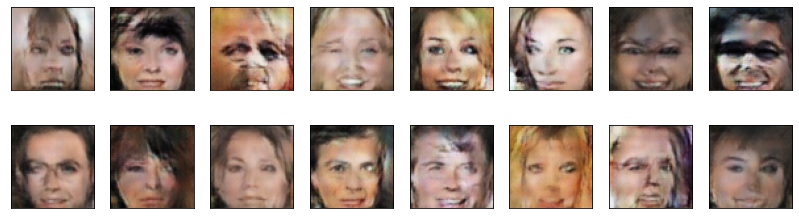

2025-08-01 02:30:55 | Epoch [5/25] | Batch 0/509 | d_loss: 0.4210 | g_loss: 3.4119
2025-08-01 02:30:57 | Epoch [5/25] | Batch 50/509 | d_loss: 0.3872 | g_loss: 4.0072
2025-08-01 02:31:00 | Epoch [5/25] | Batch 100/509 | d_loss: 0.4821 | g_loss: 4.6235
2025-08-01 02:31:03 | Epoch [5/25] | Batch 150/509 | d_loss: 0.4081 | g_loss: 3.9645
2025-08-01 02:31:06 | Epoch [5/25] | Batch 200/509 | d_loss: 0.4130 | g_loss: 3.8162
2025-08-01 02:31:08 | Epoch [5/25] | Batch 250/509 | d_loss: 0.3839 | g_loss: 3.4959
2025-08-01 02:31:11 | Epoch [5/25] | Batch 300/509 | d_loss: 0.4065 | g_loss: 3.8870
2025-08-01 02:31:14 | Epoch [5/25] | Batch 350/509 | d_loss: 0.4196 | g_loss: 3.9434
2025-08-01 02:31:17 | Epoch [5/25] | Batch 400/509 | d_loss: 0.4096 | g_loss: 3.6372
2025-08-01 02:31:19 | Epoch [5/25] | Batch 450/509 | d_loss: 0.4098 | g_loss: 4.2561
2025-08-01 02:31:22 | Epoch [5/25] | Batch 500/509 | d_loss: 0.4263 | g_loss: 3.8640


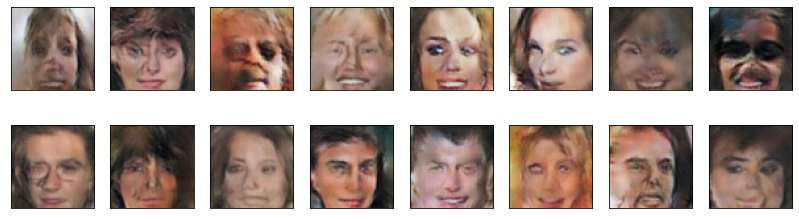

2025-08-01 02:31:26 | Epoch [6/25] | Batch 0/509 | d_loss: 0.4175 | g_loss: 3.6703
2025-08-01 02:31:29 | Epoch [6/25] | Batch 50/509 | d_loss: 0.5146 | g_loss: 3.9183
2025-08-01 02:31:32 | Epoch [6/25] | Batch 100/509 | d_loss: 0.4194 | g_loss: 4.0696
2025-08-01 02:31:34 | Epoch [6/25] | Batch 150/509 | d_loss: 0.4082 | g_loss: 3.7006
2025-08-01 02:31:37 | Epoch [6/25] | Batch 200/509 | d_loss: 0.6495 | g_loss: 5.9852
2025-08-01 02:31:40 | Epoch [6/25] | Batch 250/509 | d_loss: 0.4086 | g_loss: 3.8504
2025-08-01 02:31:43 | Epoch [6/25] | Batch 300/509 | d_loss: 0.4024 | g_loss: 3.6189
2025-08-01 02:31:45 | Epoch [6/25] | Batch 350/509 | d_loss: 0.3972 | g_loss: 3.8551
2025-08-01 02:31:48 | Epoch [6/25] | Batch 400/509 | d_loss: 0.4883 | g_loss: 3.3092
2025-08-01 02:31:51 | Epoch [6/25] | Batch 450/509 | d_loss: 0.4575 | g_loss: 3.8475
2025-08-01 02:31:54 | Epoch [6/25] | Batch 500/509 | d_loss: 0.3705 | g_loss: 4.9558


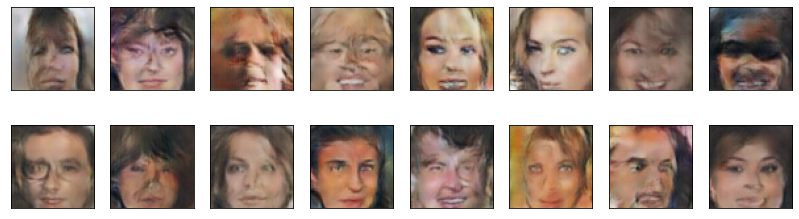

2025-08-01 02:31:57 | Epoch [7/25] | Batch 0/509 | d_loss: 0.3975 | g_loss: 3.9258
2025-08-01 02:32:00 | Epoch [7/25] | Batch 50/509 | d_loss: 0.4512 | g_loss: 3.8861
2025-08-01 02:32:03 | Epoch [7/25] | Batch 100/509 | d_loss: 0.4856 | g_loss: 3.1684
2025-08-01 02:32:05 | Epoch [7/25] | Batch 150/509 | d_loss: 0.3645 | g_loss: 3.7107
2025-08-01 02:32:08 | Epoch [7/25] | Batch 200/509 | d_loss: 0.4052 | g_loss: 3.6987
2025-08-01 02:32:11 | Epoch [7/25] | Batch 250/509 | d_loss: 0.3806 | g_loss: 3.9211
2025-08-01 02:32:14 | Epoch [7/25] | Batch 300/509 | d_loss: 0.4228 | g_loss: 3.9144
2025-08-01 02:32:16 | Epoch [7/25] | Batch 350/509 | d_loss: 0.4122 | g_loss: 4.7661
2025-08-01 02:32:19 | Epoch [7/25] | Batch 400/509 | d_loss: 0.3935 | g_loss: 3.8675
2025-08-01 02:32:22 | Epoch [7/25] | Batch 450/509 | d_loss: 0.4072 | g_loss: 3.5609
2025-08-01 02:32:25 | Epoch [7/25] | Batch 500/509 | d_loss: 0.3773 | g_loss: 4.4320


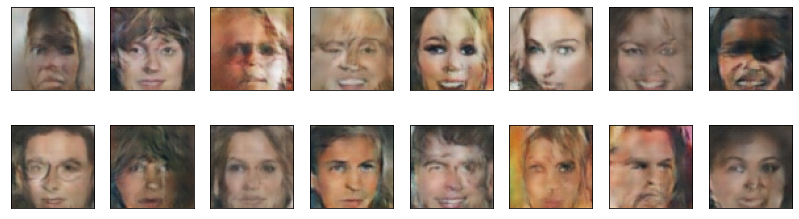

2025-08-01 02:32:28 | Epoch [8/25] | Batch 0/509 | d_loss: 0.4175 | g_loss: 3.8524
2025-08-01 02:32:30 | Epoch [8/25] | Batch 50/509 | d_loss: 0.5918 | g_loss: 3.7881
2025-08-01 02:32:33 | Epoch [8/25] | Batch 100/509 | d_loss: 0.9104 | g_loss: 4.8306
2025-08-01 02:32:36 | Epoch [8/25] | Batch 150/509 | d_loss: 0.4162 | g_loss: 3.5448
2025-08-01 02:32:39 | Epoch [8/25] | Batch 200/509 | d_loss: 0.3694 | g_loss: 4.1305
2025-08-01 02:32:41 | Epoch [8/25] | Batch 250/509 | d_loss: 0.5140 | g_loss: 4.0594
2025-08-01 02:32:44 | Epoch [8/25] | Batch 300/509 | d_loss: 0.3770 | g_loss: 3.7921
2025-08-01 02:32:47 | Epoch [8/25] | Batch 350/509 | d_loss: 0.4732 | g_loss: 3.1117
2025-08-01 02:32:50 | Epoch [8/25] | Batch 400/509 | d_loss: 0.5180 | g_loss: 4.1940
2025-08-01 02:32:52 | Epoch [8/25] | Batch 450/509 | d_loss: 0.4045 | g_loss: 4.0283
2025-08-01 02:32:55 | Epoch [8/25] | Batch 500/509 | d_loss: 0.5749 | g_loss: 4.4512


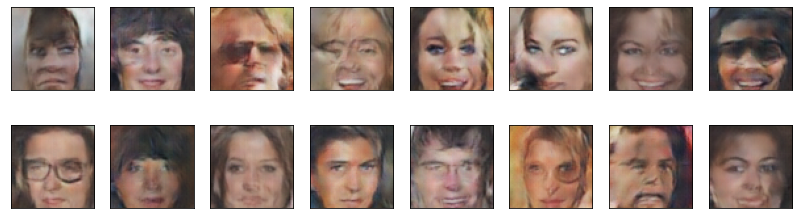

2025-08-01 02:32:58 | Epoch [9/25] | Batch 0/509 | d_loss: 0.3617 | g_loss: 4.3478
2025-08-01 02:33:01 | Epoch [9/25] | Batch 50/509 | d_loss: 0.6330 | g_loss: 4.5927
2025-08-01 02:33:03 | Epoch [9/25] | Batch 100/509 | d_loss: 0.5354 | g_loss: 4.2633
2025-08-01 02:33:06 | Epoch [9/25] | Batch 150/509 | d_loss: 0.3845 | g_loss: 3.7279
2025-08-01 02:33:09 | Epoch [9/25] | Batch 200/509 | d_loss: 0.7191 | g_loss: 4.0079
2025-08-01 02:33:12 | Epoch [9/25] | Batch 250/509 | d_loss: 0.3801 | g_loss: 3.9886
2025-08-01 02:33:14 | Epoch [9/25] | Batch 300/509 | d_loss: 0.4009 | g_loss: 3.5785
2025-08-01 02:33:17 | Epoch [9/25] | Batch 350/509 | d_loss: 0.4094 | g_loss: 3.6243
2025-08-01 02:33:20 | Epoch [9/25] | Batch 400/509 | d_loss: 0.5314 | g_loss: 3.5499
2025-08-01 02:33:23 | Epoch [9/25] | Batch 450/509 | d_loss: 0.3740 | g_loss: 3.7812
2025-08-01 02:33:25 | Epoch [9/25] | Batch 500/509 | d_loss: 0.5916 | g_loss: 3.7272


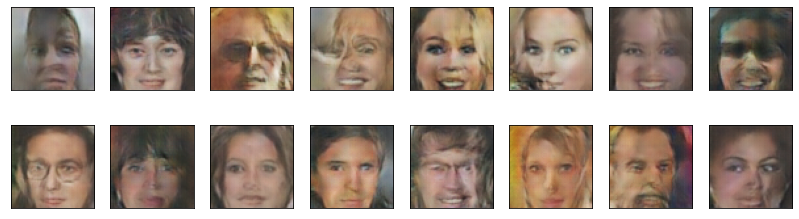

2025-08-01 02:33:29 | Epoch [10/25] | Batch 0/509 | d_loss: 0.3940 | g_loss: 3.8301
2025-08-01 02:33:32 | Epoch [10/25] | Batch 50/509 | d_loss: 0.4896 | g_loss: 3.9261
2025-08-01 02:33:34 | Epoch [10/25] | Batch 100/509 | d_loss: 0.4910 | g_loss: 3.6476
2025-08-01 02:33:37 | Epoch [10/25] | Batch 150/509 | d_loss: 0.4474 | g_loss: 3.4902
2025-08-01 02:33:40 | Epoch [10/25] | Batch 200/509 | d_loss: 0.4006 | g_loss: 4.3711
2025-08-01 02:33:43 | Epoch [10/25] | Batch 250/509 | d_loss: 0.4543 | g_loss: 3.1541
2025-08-01 02:33:45 | Epoch [10/25] | Batch 300/509 | d_loss: 0.4106 | g_loss: 4.2403
2025-08-01 02:33:48 | Epoch [10/25] | Batch 350/509 | d_loss: 0.3992 | g_loss: 4.0089
2025-08-01 02:33:51 | Epoch [10/25] | Batch 400/509 | d_loss: 0.4035 | g_loss: 3.2650
2025-08-01 02:33:53 | Epoch [10/25] | Batch 450/509 | d_loss: 0.6558 | g_loss: 4.1653
2025-08-01 02:33:56 | Epoch [10/25] | Batch 500/509 | d_loss: 1.6562 | g_loss: 6.5219


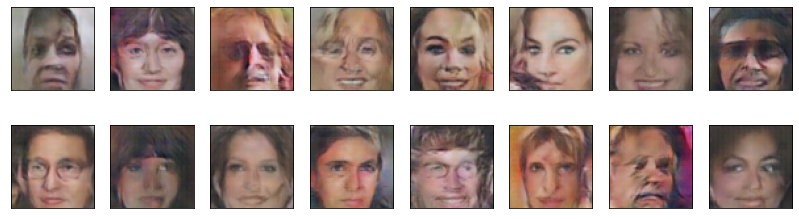

2025-08-01 02:33:59 | Epoch [11/25] | Batch 0/509 | d_loss: 0.4034 | g_loss: 3.6719
2025-08-01 02:34:02 | Epoch [11/25] | Batch 50/509 | d_loss: 0.3769 | g_loss: 4.1766
2025-08-01 02:34:05 | Epoch [11/25] | Batch 100/509 | d_loss: 0.3673 | g_loss: 4.6673
2025-08-01 02:34:07 | Epoch [11/25] | Batch 150/509 | d_loss: 0.3787 | g_loss: 4.7073
2025-08-01 02:34:10 | Epoch [11/25] | Batch 200/509 | d_loss: 0.7150 | g_loss: 4.2754
2025-08-01 02:34:13 | Epoch [11/25] | Batch 250/509 | d_loss: 0.3803 | g_loss: 4.7163
2025-08-01 02:34:15 | Epoch [11/25] | Batch 300/509 | d_loss: 0.4123 | g_loss: 4.6665
2025-08-01 02:34:18 | Epoch [11/25] | Batch 350/509 | d_loss: 0.5161 | g_loss: 3.3177
2025-08-01 02:34:21 | Epoch [11/25] | Batch 400/509 | d_loss: 0.5077 | g_loss: 4.1185
2025-08-01 02:34:24 | Epoch [11/25] | Batch 450/509 | d_loss: 0.4438 | g_loss: 3.3291
2025-08-01 02:34:26 | Epoch [11/25] | Batch 500/509 | d_loss: 0.3715 | g_loss: 4.4060


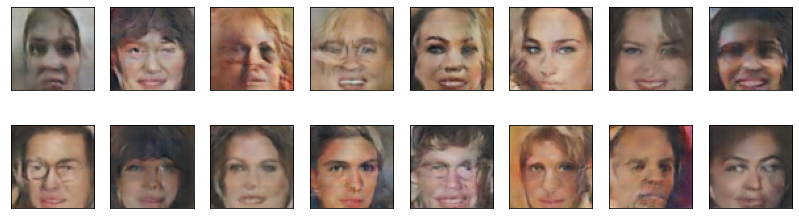

2025-08-01 02:34:29 | Epoch [12/25] | Batch 0/509 | d_loss: 0.3719 | g_loss: 4.1689
2025-08-01 02:34:32 | Epoch [12/25] | Batch 50/509 | d_loss: 0.3663 | g_loss: 4.6671
2025-08-01 02:34:35 | Epoch [12/25] | Batch 100/509 | d_loss: 0.3853 | g_loss: 3.6452
2025-08-01 02:34:37 | Epoch [12/25] | Batch 150/509 | d_loss: 0.4169 | g_loss: 3.5701
2025-08-01 02:34:40 | Epoch [12/25] | Batch 200/509 | d_loss: 0.4173 | g_loss: 3.6225
2025-08-01 02:34:43 | Epoch [12/25] | Batch 250/509 | d_loss: 0.4003 | g_loss: 4.4272
2025-08-01 02:34:45 | Epoch [12/25] | Batch 300/509 | d_loss: 0.4080 | g_loss: 3.5275
2025-08-01 02:34:48 | Epoch [12/25] | Batch 350/509 | d_loss: 0.3765 | g_loss: 3.9421
2025-08-01 02:34:51 | Epoch [12/25] | Batch 400/509 | d_loss: 0.4727 | g_loss: 3.1541
2025-08-01 02:34:54 | Epoch [12/25] | Batch 450/509 | d_loss: 0.3892 | g_loss: 4.1933
2025-08-01 02:34:56 | Epoch [12/25] | Batch 500/509 | d_loss: 0.3677 | g_loss: 3.6189


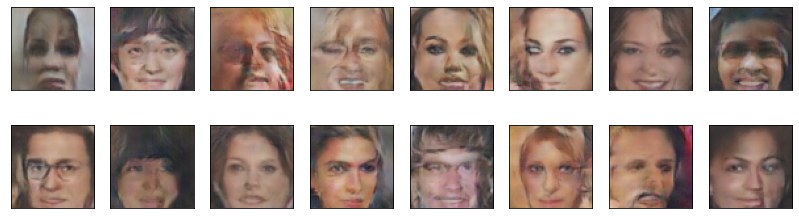

2025-08-01 02:35:00 | Epoch [13/25] | Batch 0/509 | d_loss: 0.3908 | g_loss: 3.7995
2025-08-01 02:35:02 | Epoch [13/25] | Batch 50/509 | d_loss: 0.3802 | g_loss: 4.3855
2025-08-01 02:35:05 | Epoch [13/25] | Batch 100/509 | d_loss: 0.3730 | g_loss: 3.6512
2025-08-01 02:35:08 | Epoch [13/25] | Batch 150/509 | d_loss: 0.4030 | g_loss: 3.7977
2025-08-01 02:35:11 | Epoch [13/25] | Batch 200/509 | d_loss: 0.6782 | g_loss: 4.8702
2025-08-01 02:35:13 | Epoch [13/25] | Batch 250/509 | d_loss: 0.4132 | g_loss: 3.4375
2025-08-01 02:35:16 | Epoch [13/25] | Batch 300/509 | d_loss: 0.4509 | g_loss: 3.5448
2025-08-01 02:35:19 | Epoch [13/25] | Batch 350/509 | d_loss: 0.3770 | g_loss: 3.7179
2025-08-01 02:35:22 | Epoch [13/25] | Batch 400/509 | d_loss: 0.3870 | g_loss: 3.2238
2025-08-01 02:35:24 | Epoch [13/25] | Batch 450/509 | d_loss: 0.6791 | g_loss: 4.2858
2025-08-01 02:35:27 | Epoch [13/25] | Batch 500/509 | d_loss: 0.4233 | g_loss: 4.3238


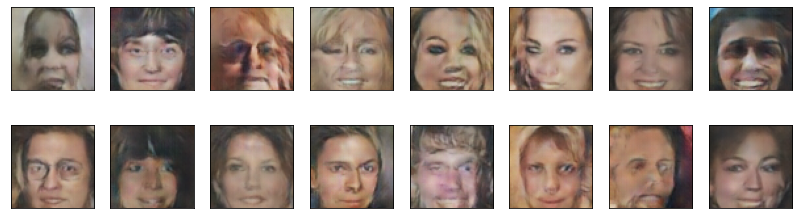

2025-08-01 02:35:30 | Epoch [14/25] | Batch 0/509 | d_loss: 0.4313 | g_loss: 4.3392
2025-08-01 02:35:33 | Epoch [14/25] | Batch 50/509 | d_loss: 0.3790 | g_loss: 3.8572
2025-08-01 02:35:35 | Epoch [14/25] | Batch 100/509 | d_loss: 0.4496 | g_loss: 3.7538
2025-08-01 02:35:38 | Epoch [14/25] | Batch 150/509 | d_loss: 0.3583 | g_loss: 4.2555
2025-08-01 02:35:41 | Epoch [14/25] | Batch 200/509 | d_loss: 0.5218 | g_loss: 3.4827
2025-08-01 02:35:44 | Epoch [14/25] | Batch 250/509 | d_loss: 0.5127 | g_loss: 3.6631
2025-08-01 02:35:46 | Epoch [14/25] | Batch 300/509 | d_loss: 0.4003 | g_loss: 3.4920
2025-08-01 02:35:49 | Epoch [14/25] | Batch 350/509 | d_loss: 0.4174 | g_loss: 3.8040
2025-08-01 02:35:52 | Epoch [14/25] | Batch 400/509 | d_loss: 0.3777 | g_loss: 4.6496
2025-08-01 02:35:55 | Epoch [14/25] | Batch 450/509 | d_loss: 0.3996 | g_loss: 3.6620
2025-08-01 02:35:57 | Epoch [14/25] | Batch 500/509 | d_loss: 0.3895 | g_loss: 3.7421


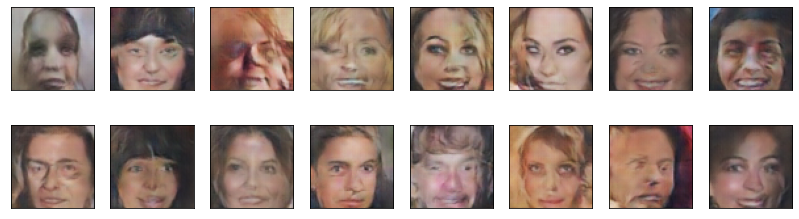

2025-08-01 02:36:01 | Epoch [15/25] | Batch 0/509 | d_loss: 0.5412 | g_loss: 3.8989
2025-08-01 02:36:04 | Epoch [15/25] | Batch 50/509 | d_loss: 0.4127 | g_loss: 3.8311
2025-08-01 02:36:06 | Epoch [15/25] | Batch 100/509 | d_loss: 0.5249 | g_loss: 3.1942
2025-08-01 02:36:09 | Epoch [15/25] | Batch 150/509 | d_loss: 0.7918 | g_loss: 0.6743
2025-08-01 02:36:12 | Epoch [15/25] | Batch 200/509 | d_loss: 0.3997 | g_loss: 4.0137
2025-08-01 02:36:14 | Epoch [15/25] | Batch 250/509 | d_loss: 0.6977 | g_loss: 3.8646
2025-08-01 02:36:17 | Epoch [15/25] | Batch 300/509 | d_loss: 0.4574 | g_loss: 2.9297
2025-08-01 02:36:20 | Epoch [15/25] | Batch 350/509 | d_loss: 0.3623 | g_loss: 4.1833
2025-08-01 02:36:23 | Epoch [15/25] | Batch 400/509 | d_loss: 0.5808 | g_loss: 5.3811
2025-08-01 02:36:25 | Epoch [15/25] | Batch 450/509 | d_loss: 0.3842 | g_loss: 3.8381
2025-08-01 02:36:28 | Epoch [15/25] | Batch 500/509 | d_loss: 0.4163 | g_loss: 3.6017


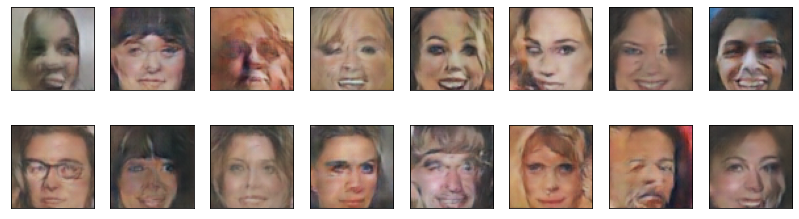

2025-08-01 02:36:31 | Epoch [16/25] | Batch 0/509 | d_loss: 0.3962 | g_loss: 4.3639
2025-08-01 02:36:34 | Epoch [16/25] | Batch 50/509 | d_loss: 0.3921 | g_loss: 4.2147
2025-08-01 02:36:37 | Epoch [16/25] | Batch 100/509 | d_loss: 0.4597 | g_loss: 3.4564
2025-08-01 02:36:39 | Epoch [16/25] | Batch 150/509 | d_loss: 0.6318 | g_loss: 3.0997
2025-08-01 02:36:42 | Epoch [16/25] | Batch 200/509 | d_loss: 0.4197 | g_loss: 4.5283
2025-08-01 02:36:45 | Epoch [16/25] | Batch 250/509 | d_loss: 0.3665 | g_loss: 4.5158
2025-08-01 02:36:47 | Epoch [16/25] | Batch 300/509 | d_loss: 0.3828 | g_loss: 3.9021
2025-08-01 02:36:50 | Epoch [16/25] | Batch 350/509 | d_loss: 0.4503 | g_loss: 3.4470
2025-08-01 02:36:53 | Epoch [16/25] | Batch 400/509 | d_loss: 0.3648 | g_loss: 4.3816
2025-08-01 02:36:56 | Epoch [16/25] | Batch 450/509 | d_loss: 0.3762 | g_loss: 3.9999
2025-08-01 02:36:58 | Epoch [16/25] | Batch 500/509 | d_loss: 0.4922 | g_loss: 3.5937


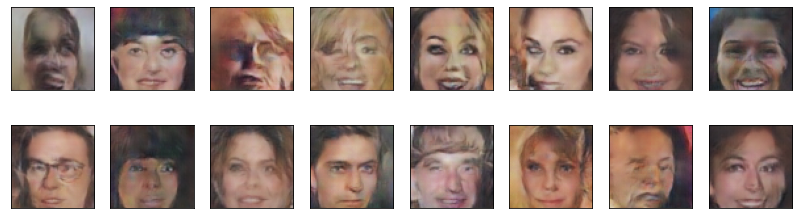

2025-08-01 02:37:02 | Epoch [17/25] | Batch 0/509 | d_loss: 0.3595 | g_loss: 4.2491
2025-08-01 02:37:05 | Epoch [17/25] | Batch 50/509 | d_loss: 0.3457 | g_loss: 4.8536
2025-08-01 02:37:07 | Epoch [17/25] | Batch 100/509 | d_loss: 0.4459 | g_loss: 4.4615
2025-08-01 02:37:10 | Epoch [17/25] | Batch 150/509 | d_loss: 0.3757 | g_loss: 4.0638
2025-08-01 02:37:13 | Epoch [17/25] | Batch 200/509 | d_loss: 0.4661 | g_loss: 3.7930
2025-08-01 02:37:16 | Epoch [17/25] | Batch 250/509 | d_loss: 0.3770 | g_loss: 4.1727
2025-08-01 02:37:18 | Epoch [17/25] | Batch 300/509 | d_loss: 0.4455 | g_loss: 4.2154
2025-08-01 02:37:21 | Epoch [17/25] | Batch 350/509 | d_loss: 0.3584 | g_loss: 4.3742
2025-08-01 02:37:24 | Epoch [17/25] | Batch 400/509 | d_loss: 0.4044 | g_loss: 3.5355
2025-08-01 02:37:26 | Epoch [17/25] | Batch 450/509 | d_loss: 0.3694 | g_loss: 4.7196
2025-08-01 02:37:29 | Epoch [17/25] | Batch 500/509 | d_loss: 0.3678 | g_loss: 4.3094


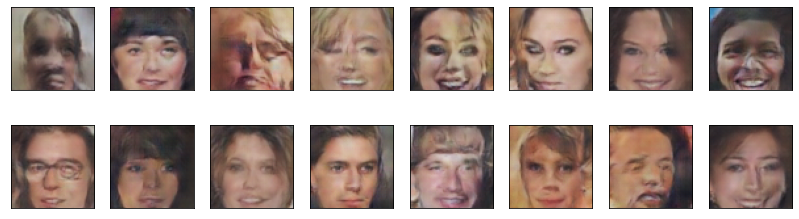

2025-08-01 02:37:32 | Epoch [18/25] | Batch 0/509 | d_loss: 0.3609 | g_loss: 4.5058
2025-08-01 02:37:35 | Epoch [18/25] | Batch 50/509 | d_loss: 0.3685 | g_loss: 4.2118
2025-08-01 02:37:38 | Epoch [18/25] | Batch 100/509 | d_loss: 0.4243 | g_loss: 4.3482
2025-08-01 02:37:40 | Epoch [18/25] | Batch 150/509 | d_loss: 0.9827 | g_loss: 3.3300
2025-08-01 02:37:43 | Epoch [18/25] | Batch 200/509 | d_loss: 0.3957 | g_loss: 4.1088
2025-08-01 02:37:46 | Epoch [18/25] | Batch 250/509 | d_loss: 0.3811 | g_loss: 4.0425
2025-08-01 02:37:49 | Epoch [18/25] | Batch 300/509 | d_loss: 0.4814 | g_loss: 3.9353
2025-08-01 02:37:51 | Epoch [18/25] | Batch 350/509 | d_loss: 0.6429 | g_loss: 2.3387
2025-08-01 02:37:54 | Epoch [18/25] | Batch 400/509 | d_loss: 0.4021 | g_loss: 3.9876
2025-08-01 02:37:57 | Epoch [18/25] | Batch 450/509 | d_loss: 0.3629 | g_loss: 4.3300
2025-08-01 02:38:00 | Epoch [18/25] | Batch 500/509 | d_loss: 0.3635 | g_loss: 4.1344


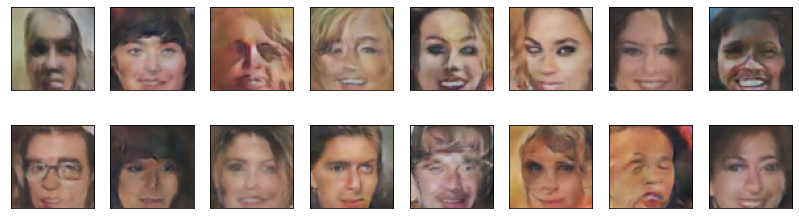

2025-08-01 02:38:03 | Epoch [19/25] | Batch 0/509 | d_loss: 0.4236 | g_loss: 3.7407
2025-08-01 02:38:05 | Epoch [19/25] | Batch 50/509 | d_loss: 0.5532 | g_loss: 4.2340
2025-08-01 02:38:08 | Epoch [19/25] | Batch 100/509 | d_loss: 0.3634 | g_loss: 4.5657
2025-08-01 02:38:11 | Epoch [19/25] | Batch 150/509 | d_loss: 0.4901 | g_loss: 3.8368
2025-08-01 02:38:14 | Epoch [19/25] | Batch 200/509 | d_loss: 0.3664 | g_loss: 4.7477
2025-08-01 02:38:16 | Epoch [19/25] | Batch 250/509 | d_loss: 0.3770 | g_loss: 3.7282
2025-08-01 02:38:19 | Epoch [19/25] | Batch 300/509 | d_loss: 0.3855 | g_loss: 3.6145
2025-08-01 02:38:22 | Epoch [19/25] | Batch 350/509 | d_loss: 0.3531 | g_loss: 4.2888
2025-08-01 02:38:25 | Epoch [19/25] | Batch 400/509 | d_loss: 0.3534 | g_loss: 4.0250
2025-08-01 02:38:27 | Epoch [19/25] | Batch 450/509 | d_loss: 0.3826 | g_loss: 4.5811
2025-08-01 02:38:30 | Epoch [19/25] | Batch 500/509 | d_loss: 0.3831 | g_loss: 4.6117


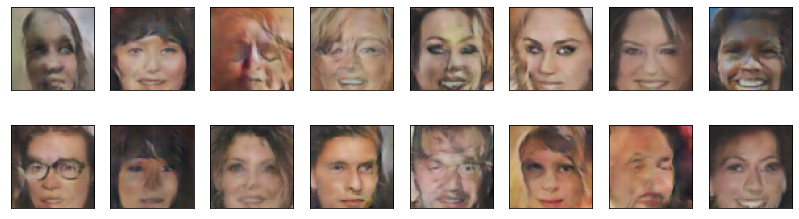

2025-08-01 02:38:33 | Epoch [20/25] | Batch 0/509 | d_loss: 0.3604 | g_loss: 5.5043
2025-08-01 02:38:36 | Epoch [20/25] | Batch 50/509 | d_loss: 0.5586 | g_loss: 3.9157
2025-08-01 02:38:39 | Epoch [20/25] | Batch 100/509 | d_loss: 0.4364 | g_loss: 3.8457
2025-08-01 02:38:42 | Epoch [20/25] | Batch 150/509 | d_loss: 0.6613 | g_loss: 4.4802
2025-08-01 02:38:44 | Epoch [20/25] | Batch 200/509 | d_loss: 0.4104 | g_loss: 4.5048
2025-08-01 02:38:47 | Epoch [20/25] | Batch 250/509 | d_loss: 0.4104 | g_loss: 3.8340
2025-08-01 02:38:50 | Epoch [20/25] | Batch 300/509 | d_loss: 0.3733 | g_loss: 3.9856
2025-08-01 02:38:53 | Epoch [20/25] | Batch 350/509 | d_loss: 1.1777 | g_loss: 6.5175
2025-08-01 02:38:55 | Epoch [20/25] | Batch 400/509 | d_loss: 0.3560 | g_loss: 3.5200
2025-08-01 02:38:58 | Epoch [20/25] | Batch 450/509 | d_loss: 0.4747 | g_loss: 3.3896
2025-08-01 02:39:01 | Epoch [20/25] | Batch 500/509 | d_loss: 0.3526 | g_loss: 4.5035


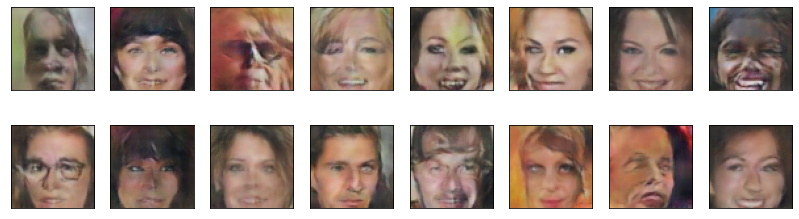

2025-08-01 02:39:04 | Epoch [21/25] | Batch 0/509 | d_loss: 0.3469 | g_loss: 4.4750
2025-08-01 02:39:07 | Epoch [21/25] | Batch 50/509 | d_loss: 0.3848 | g_loss: 3.8850
2025-08-01 02:39:09 | Epoch [21/25] | Batch 100/509 | d_loss: 0.5318 | g_loss: 2.4936
2025-08-01 02:39:12 | Epoch [21/25] | Batch 150/509 | d_loss: 0.3685 | g_loss: 3.6433
2025-08-01 02:39:15 | Epoch [21/25] | Batch 200/509 | d_loss: 0.4150 | g_loss: 4.2330
2025-08-01 02:39:18 | Epoch [21/25] | Batch 250/509 | d_loss: 0.3684 | g_loss: 4.5705
2025-08-01 02:39:20 | Epoch [21/25] | Batch 300/509 | d_loss: 0.4052 | g_loss: 4.5297
2025-08-01 02:39:23 | Epoch [21/25] | Batch 350/509 | d_loss: 0.3946 | g_loss: 4.5945
2025-08-01 02:39:26 | Epoch [21/25] | Batch 400/509 | d_loss: 0.3790 | g_loss: 4.5075
2025-08-01 02:39:28 | Epoch [21/25] | Batch 450/509 | d_loss: 0.4680 | g_loss: 3.0611
2025-08-01 02:39:31 | Epoch [21/25] | Batch 500/509 | d_loss: 0.3750 | g_loss: 4.8273


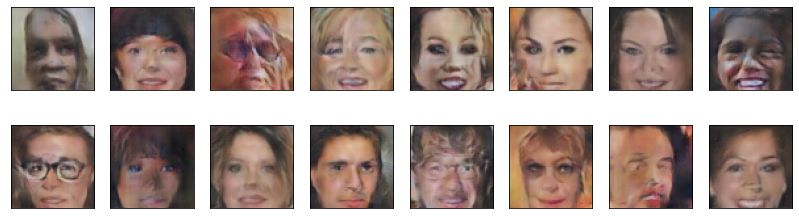

2025-08-01 02:39:34 | Epoch [22/25] | Batch 0/509 | d_loss: 0.3856 | g_loss: 3.7735
2025-08-01 02:39:37 | Epoch [22/25] | Batch 50/509 | d_loss: 0.4468 | g_loss: 4.2680
2025-08-01 02:39:40 | Epoch [22/25] | Batch 100/509 | d_loss: 0.3835 | g_loss: 3.6699
2025-08-01 02:39:43 | Epoch [22/25] | Batch 150/509 | d_loss: 0.3623 | g_loss: 3.9779
2025-08-01 02:39:45 | Epoch [22/25] | Batch 200/509 | d_loss: 0.3560 | g_loss: 4.5546
2025-08-01 02:39:48 | Epoch [22/25] | Batch 250/509 | d_loss: 0.3606 | g_loss: 4.8461
2025-08-01 02:39:51 | Epoch [22/25] | Batch 300/509 | d_loss: 0.3951 | g_loss: 3.5534
2025-08-01 02:39:54 | Epoch [22/25] | Batch 350/509 | d_loss: 0.4244 | g_loss: 4.0497
2025-08-01 02:39:56 | Epoch [22/25] | Batch 400/509 | d_loss: 0.4806 | g_loss: 5.0565
2025-08-01 02:39:59 | Epoch [22/25] | Batch 450/509 | d_loss: 0.3570 | g_loss: 4.5845
2025-08-01 02:40:02 | Epoch [22/25] | Batch 500/509 | d_loss: 1.9737 | g_loss: 3.6467


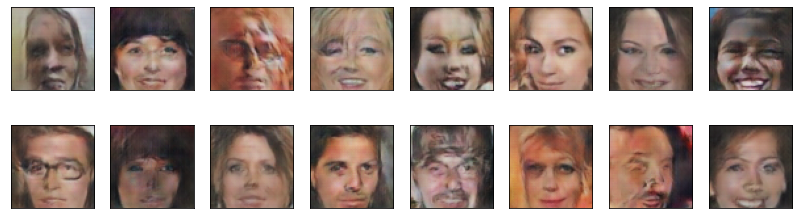

2025-08-01 02:40:05 | Epoch [23/25] | Batch 0/509 | d_loss: 0.4668 | g_loss: 2.9862
2025-08-01 02:40:08 | Epoch [23/25] | Batch 50/509 | d_loss: 0.6758 | g_loss: 4.2112
2025-08-01 02:40:11 | Epoch [23/25] | Batch 100/509 | d_loss: 0.3540 | g_loss: 3.6687
2025-08-01 02:40:14 | Epoch [23/25] | Batch 150/509 | d_loss: 0.3709 | g_loss: 4.2962
2025-08-01 02:40:16 | Epoch [23/25] | Batch 200/509 | d_loss: 0.3517 | g_loss: 4.2775
2025-08-01 02:40:19 | Epoch [23/25] | Batch 250/509 | d_loss: 0.4793 | g_loss: 3.2184
2025-08-01 02:40:22 | Epoch [23/25] | Batch 300/509 | d_loss: 0.3625 | g_loss: 4.6039
2025-08-01 02:40:24 | Epoch [23/25] | Batch 350/509 | d_loss: 0.4009 | g_loss: 4.4955
2025-08-01 02:40:27 | Epoch [23/25] | Batch 400/509 | d_loss: 0.6143 | g_loss: 4.5747
2025-08-01 02:40:30 | Epoch [23/25] | Batch 450/509 | d_loss: 0.5937 | g_loss: 3.9686
2025-08-01 02:40:33 | Epoch [23/25] | Batch 500/509 | d_loss: 0.3634 | g_loss: 3.5202


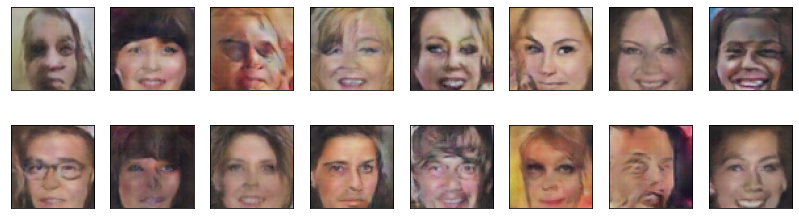

2025-08-01 02:40:36 | Epoch [24/25] | Batch 0/509 | d_loss: 0.3623 | g_loss: 4.3966
2025-08-01 02:40:39 | Epoch [24/25] | Batch 50/509 | d_loss: 0.4395 | g_loss: 4.0281
2025-08-01 02:40:42 | Epoch [24/25] | Batch 100/509 | d_loss: 0.4216 | g_loss: 3.5298
2025-08-01 02:40:44 | Epoch [24/25] | Batch 150/509 | d_loss: 0.3902 | g_loss: 4.8037
2025-08-01 02:40:47 | Epoch [24/25] | Batch 200/509 | d_loss: 0.3745 | g_loss: 3.9077
2025-08-01 02:40:50 | Epoch [24/25] | Batch 250/509 | d_loss: 0.3572 | g_loss: 4.5577
2025-08-01 02:40:53 | Epoch [24/25] | Batch 300/509 | d_loss: 0.3822 | g_loss: 4.2946
2025-08-01 02:40:55 | Epoch [24/25] | Batch 350/509 | d_loss: 0.3546 | g_loss: 4.5300
2025-08-01 02:40:58 | Epoch [24/25] | Batch 400/509 | d_loss: 2.0964 | g_loss: 5.6298
2025-08-01 02:41:01 | Epoch [24/25] | Batch 450/509 | d_loss: 0.4489 | g_loss: 4.2640
2025-08-01 02:41:04 | Epoch [24/25] | Batch 500/509 | d_loss: 0.3522 | g_loss: 3.4487


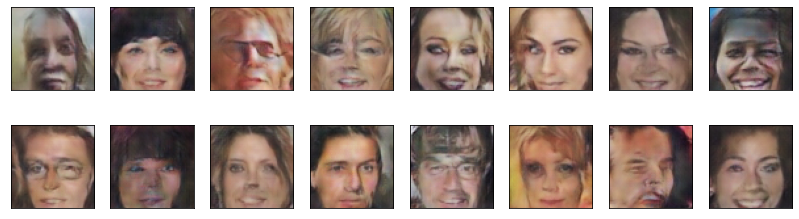

2025-08-01 02:41:06 | Epoch [25/25] | Batch 0/509 | d_loss: 0.3739 | g_loss: 4.5535
2025-08-01 02:41:09 | Epoch [25/25] | Batch 50/509 | d_loss: 0.3492 | g_loss: 5.1483
2025-08-01 02:41:12 | Epoch [25/25] | Batch 100/509 | d_loss: 0.4501 | g_loss: 4.3389
2025-08-01 02:41:15 | Epoch [25/25] | Batch 150/509 | d_loss: 0.5557 | g_loss: 3.8369
2025-08-01 02:41:17 | Epoch [25/25] | Batch 200/509 | d_loss: 0.3573 | g_loss: 4.9072
2025-08-01 02:41:20 | Epoch [25/25] | Batch 250/509 | d_loss: 0.4102 | g_loss: 3.5882
2025-08-01 02:41:23 | Epoch [25/25] | Batch 300/509 | d_loss: 0.3763 | g_loss: 3.8766
2025-08-01 02:41:26 | Epoch [25/25] | Batch 350/509 | d_loss: 0.4554 | g_loss: 3.5627
2025-08-01 02:41:28 | Epoch [25/25] | Batch 400/509 | d_loss: 0.3757 | g_loss: 4.3050
2025-08-01 02:41:31 | Epoch [25/25] | Batch 450/509 | d_loss: 0.4018 | g_loss: 4.4028
2025-08-01 02:41:34 | Epoch [25/25] | Batch 500/509 | d_loss: 0.3684 | g_loss: 4.7497


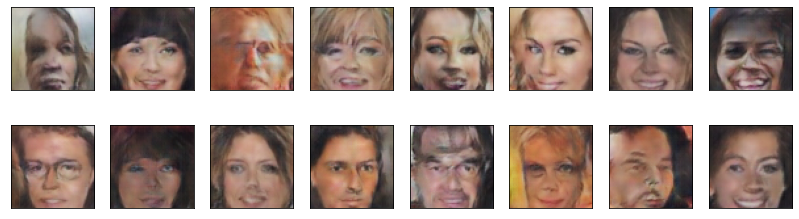

In [ ]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()

n_epochs = 25

losses = []
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        
        ######Training
                    
        for i in range(2):
            d_loss = discriminator_step(batch_size, latent_dim, real_images)
            
        g_loss = generator_step(batch_size, latent_dim)
        
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

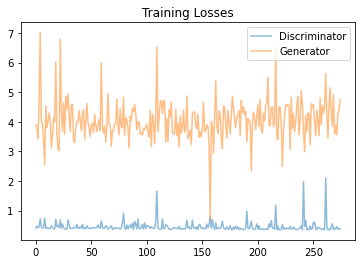

In [128]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** (Write your answer in this cell)
Different optimization strategies yielded slightly different results. Checked with torch.ones*0.0001 is used instead of zeros to compute fake_loss. which showed slightly distorted images. Training for more epochs has not generated substantially better results.
Faces which has more color has been prone to more distortion and are not recreated well than the ones with light colors. More training data is needed for more/dark color images. Images with more hair visible are not recreated well when compared to the ones with less hair. More features or more layers can be added to better distinguish and recreate features

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.